# **Install ktrain and tensorflow gpu**

In [ ]:
!pip install tensorflow-gpu
!pip install ktrain

# **Import packages**

In [2]:
import pandas as pd
import ktrain
from ktrain import text
from sklearn.model_selection import train_test_split


In [3]:
import tensorflow as tf
from tensorflow import keras


# **Read dataset as dataframe**

In [4]:
df = pd.read_csv('/content/drive/My Drive/goemotions_aug_dairai_train_cleaned.csv')

In [5]:
df.head()

,Unnamed: 0,anger,augmented,cleaned_processed,datasource,fear,joy,sadness
0,206509,0.0,0,i feel that some korea guy are handsome and so...,dairai,0.0,1.0,0.0
1,375242,0.0,0,i put my pen to paper and made a list of thing...,dairai,0.0,0.0,0.0
2,166570,1.0,0,i wish i only had to feel the pain of the pett...,dairai,0.0,0.0,0.0
3,200580,0.0,0,i feel passionate about this journey and stand...,dairai,0.0,1.0,0.0
4,300766,0.0,0,i feel like i have convinced myself of these f...,dairai,0.0,1.0,0.0


In [6]:
label = ['anger', 'fear', 'joy', 'sadness']

In [7]:
df = df.rename(columns={'cleaned_processed': 'text'})

# **do not split**

In [ ]:
train_x = df['text']

In [ ]:
train_y = df[label]

# **In last version, I split it into two subset, we only train it on training set, so we lost too many samples, especially those positive samples**

In [8]:
from sklearn.model_selection import train_test_split
_, test = train_test_split(df, test_size=0.33, random_state=42)
test_x = test['text']
test_y = test[label]

# **load model and predict**
if you want to train it again, use predictor.model to get the model, and wrap it into a ktrain learner, continue the trian process

In [9]:
p = ktrain.load_predictor('/content/drive/My Drive/albert_model_on_full_goemotions_fixed')

In [10]:
MODEL_NAME = 'albert-base-v2'

In [11]:
t = text.Transformer(MODEL_NAME, maxlen=100, class_names=label)

In [12]:
trn = t.preprocess_train(test_x.values, test_y.values)

preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 39
	99percentile : 52


Is Multi-Label? True


In [16]:
learner = ktrain.get_learner(p.model, train_data=trn, batch_size=32)

In [49]:
checkpoint_path = "/content/drive/My Drive/checkpoint_fixed_2_1"

In [50]:
learner.fit_onecycle(3e-5, 4, checkpoint_folder=checkpoint_path)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/4
4750/4750 [==============================] - 3721s 783ms/step - loss: 0.0391 - accuracy: 0.7899
Epoch 2/4
4750/4750 [==============================] - 3718s 783ms/step - loss: 0.0452 - accuracy: 0.7883
Epoch 3/4
4750/4750 [==============================] - 3716s 782ms/step - loss: 0.0416 - accuracy: 0.7909
Epoch 4/4
4750/4750 [==============================] - 3715s 782ms/step - loss: 0.0165 - accuracy: 0.7890


# **Save Model as a predictor**

In [51]:
p = ktrain.get_predictor(learner.model, preproc=t)

In [52]:
p.predict('love surface love lavender')

[('anger', 0.00034960156),
 ('fear', 0.00071581104),
 ('joy', 0.99986315),
 ('sadness', 0.0007903535)]

In [53]:
p.save('/content/drive/My Drive/albert_model_on_full_goemotions_fixed_2')

# **Evaluate on processed isear dataset**

In [18]:
df_val = pd.read_csv('/content/drive/My Drive/isear_processed_emotions.csv')

In [22]:
df_val.head()

,text,emotions
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust


In [23]:
def make_label(emotion):
  global label
  label_single = [0, 0, 0, 0]
  if emotion in label:
    label_single[label.index(emotion)] = 1
  return label_single


In [24]:
df_val['label'] = df_val['emotions'].apply(make_label)

In [25]:
df_val.head()


,text,emotions,label
0,"During the period of falling in love, each tim...",joy,"[0, 0, 1, 0]"
1,When I was involved in a traffic accident.,fear,"[0, 1, 0, 0]"
2,When I was driving home after several days of...,anger,"[1, 0, 0, 0]"
3,When I lost the person who meant the most to me.,sadness,"[0, 0, 0, 1]"
4,The time I knocked a deer down - the sight of ...,disgust,"[0, 0, 0, 0]"


**add some very simple preprocess**


1.   lower case
2.   remove punctuation



In [26]:
def low(text):
  return text.lower()
df_val['text'] = df_val['text'].apply(low)

In [27]:
import string
def punc(text):
  return "".join([char for char in text if char not in string.punctuation])
df_val['text'] = df_val['text'].apply(punc)

In [28]:
df_val.loc[0, 'text']

'during the period of falling in love each time that we met and ã¡ especially when we had not met for a long time'

In [29]:
def rm_special(text):
  return text.replace('ã¡', '')
df_val['text'] = df_val['text'].apply(rm_special)

In [30]:
df_val.head()

,text,emotions,label
0,during the period of falling in love each time...,joy,"[0, 0, 1, 0]"
1,when i was involved in a traffic accident,fear,"[0, 1, 0, 0]"
2,when i was driving home after several days of...,anger,"[1, 0, 0, 0]"
3,when i lost the person who meant the most to me,sadness,"[0, 0, 0, 1]"
4,the time i knocked a deer down the sight of t...,disgust,"[0, 0, 0, 0]"


In [31]:
df_val.to_csv('/content/drive/My Drive/isear_val.csv')

In [32]:
test_x = df_val['text'].values

In [33]:
import numpy as np

test_y = []
for l in df_val.label:
  test_y.append(l)
test_y = np.array(test_y)

In [34]:
test_x.shape

(7666,)

In [35]:
test_y.shape

(7666, 4)

In [54]:
pred_y = np.array(p.predict(test_x))[:, :, 1]
pred_y = pred_y.astype('float')

In [55]:
from tqdm import tqdm
for i in tqdm(range(len(test_y))):
  for j in range(4):
    pred_y[i][j] = 1 if pred_y[i][j] > 0.5 else 0

100%|██████████| 7666/7666 [00:00<00:00, 245703.79it/s]


**Overall precision recall and f1 with threshold 0.5**

In [56]:
from sklearn.metrics import recall_score, precision_score, f1_score, hamming_loss

In [69]:
recall_score(test_y, pred_y, average='macro')

0.7856388142416715

In [68]:
precision_score(test_y, pred_y, average='macro')

0.604962016981629

In [70]:
f1_score(test_y, pred_y, average='macro')

0.6568241951023224

anger score



In [60]:
pred_anger = pred_y[:, 0]
test_anger = test_y[:, 0]
print('f1 score:', f1_score(test_anger, pred_anger, average='macro'))
print('hamming loss:', hamming_loss(test_anger, pred_anger))

f1 score: 0.6355872408486755
hamming loss: 0.27915470910513956


fear score

In [61]:
pred_fear = pred_y[:, 1]
test_fear = test_y[:, 1]
print('f1 score:', f1_score(test_fear, pred_fear, average='macro'))
print('hamming loss:', hamming_loss(test_fear, pred_fear))

f1 score: 0.8666723586182472
hamming loss: 0.06887555439603443


joy score

In [62]:
pred_joy = pred_y[:, 2]
test_joy = test_y[:, 2]
print('f1 score:', f1_score(test_joy, pred_joy, average='macro'))
print('hamming loss:', hamming_loss(test_joy, pred_joy))

f1 score: 0.8728492055450208
hamming loss: 0.0573962953300287


sad score

In [63]:
pred_sad = pred_y[:, 3]
test_sad = test_y[:, 3]
print('f1 score:', f1_score(test_sad, pred_sad, average='macro'))
print('hamming loss:', hamming_loss(test_sad, pred_sad))

f1 score: 0.7650851644873164
hamming loss: 0.13944690842681973


perform very bad on angry; look at precision and recall

In [64]:
precision_score(test_anger, pred_anger, average='macro')

0.6393420839028273

In [65]:
recall_score(test_anger, pred_anger, average='macro')

0.7660596440355965

when I predicted a sample with angry label, it has a larger probability then we expect that it is not angry.

so maybe we should adjust the threshold, while it will affect the recall score.

In [ ]:
df['len'] = df['text'].apply(len)

In [ ]:
df.head()

,text,emotions,label,len
0,during the period of falling in love each time...,joy,"[0, 0, 1, 0]",110
1,when i was involved in a traffic accident,fear,"[0, 1, 0, 0]",41
2,when i was driving home after several days of...,anger,"[1, 0, 0, 0]",174
3,when i lost the person who meant the most to me,sadness,"[0, 0, 0, 1]",48
4,the time i knocked a deer down the sight of t...,disgust,"[0, 0, 0, 0]",215


In [ ]:
angry_samples = df[df['emotions'] == 'anger']
joy_samples = df[df['emotions'] == 'joy']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

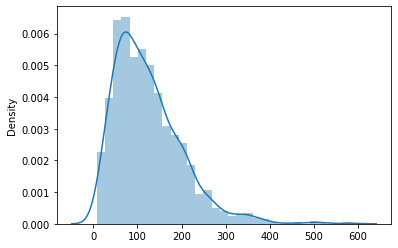

In [ ]:
sns.distplot(angry_samples['len'].values)

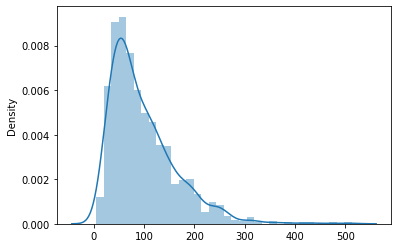

In [ ]:
sns.distplot(joy_samples['len'].values)